In [1]:
library("metacell")
library("Matrix")
library("ggplot2")
library("ggrepel")
library("tgstat")
library("zoo")
library("qvalue")
library("devtools")
library("data.table")
library("tidyverse")
library("tglkmeans")
library('RColorBrewer')


Attaching package: 'zoo'


The following objects are masked from 'package:base':

    as.Date, as.Date.numeric


Loading required package: usethis

-- Attaching packages --------------------------------------- tidyverse 1.3.1 --

v tibble  3.1.3     v dplyr   1.0.9
v tidyr   1.2.0     v stringr 1.4.0
v readr   2.1.0     v forcats 0.5.1
v purrr   0.3.4     

-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::between()   masks data.table::between()
x tidyr::expand()    masks Matrix::expand()
x dplyr::filter()    masks stats::filter()
x dplyr::first()     masks data.table::first()
x dplyr::lag()       masks stats::lag()
x dplyr::last()      masks data.table::last()
x tidyr::pack()      masks Matrix::pack()
x purrr::transpose() masks data.table::transpose()
x tidyr::unpack()    masks Matrix::unpack()



In [2]:
# source("../scripts/manifold_2d_proj_hr.R")
# scdb_init("../scrna_db/", force_reinit=T)

# mat_id <- "exe"
# mc_id <- "exe"

# mat <- scdb_mat(mat_id)
# mc <- scdb_mc(mc_id)
# gset = scdb_gset("exe")
# mc2d <- scdb_mc2d(id = "exe_umap")

# md <- mat@cell_metadata

# fig_dir <- "../figs/"
# if(!dir.exists(fig_dir)) dir.create(fig_dir)
# scfigs_init(fig_dir)

# Removing suspecious SpA metacells from manifold

In [3]:
# mat_embexe <- scdb_mat("embexe")
# mc_embexe <- scdb_mc("embexe_recolored")
# mc2d <- scdb_mc2d("exe_umap")

# suspecious_metacells <- c(539,538)

# cls_to_filter_out <- names(mc_embexe@mc)[mc_embexe@mc %in% suspecious_metacells]
# suspecious_metacells_in_exe_manifold <- unique(array(mc@mc[cls_to_filter_out]))

# filtered_mc_exe <- mc
# filtered_mc_exe@mc <- mc@mc[! mc@mc %in% cls_to_filter_out]
# filtered_mc_exe@colors <- mc@colors[-c(suspecious_metacells_in_exe_manifold)]

# scdb_add_mc(id = "exe_filtered_for_SpA_TGCs", mc = filtered_mc_exe)

# mc2d_filtered <- mc2d
# mc2d_filtered@mc_x <- mc2d_filtered@mc_x[-suspecious_metacells_in_exe_manifold]
# mc2d_filtered@mc_y <- mc2d_filtered@mc_y[-suspecious_metacells_in_exe_manifold]
# mc2d_filtered@sc_x <- mc2d_filtered@sc_x[setdiff(names(mc2d_filtered@sc_x),cls_to_filter_out)]
# mc2d_filtered@sc_y <- mc2d_filtered@sc_y[setdiff(names(mc2d_filtered@sc_y),cls_to_filter_out)]
# graph <- mc2d_filtered@graph
# graph <- graph[grep("127|128",rownames(graph), invert = T),]
# mc2d_filtered@graph <- graph

# scdb_add_mc2d(id = "exe_filtered_for_SpA_TGCs", mc2d = mc2d_filtered)

In [4]:
source("../scripts/manifold_2d_proj_hr.R")
scdb_init("../scrna_db/", force_reinit=T)

mat_id <- "exe"
mc_id <- "exe"

mat <- scdb_mat(mat_id)
mc <- scdb_mc(mc_id)
gset = scdb_gset("exe")
mc2d <- scdb_mc2d(id = "exe")

md <- mat@cell_metadata

fig_dir <- "../figs/"
if(!dir.exists(fig_dir)) dir.create(fig_dir)
scfigs_init(fig_dir)

initializing scdb to ../scrna_db/



In [5]:
exe_cells = colnames(mat@mat)[mat@cell_metadata[colnames(mat@mat),"Experiment"] != "Wildtype project"]
exe_cells_f = exe_cells[!is.na(md[exe_cells,"time_bin"])]

rank_vs_ct = table(mc@colors[mc@mc[exe_cells_f]],mat@cell_metadata[exe_cells_f,"transcriptional_rank"])
rank_vs_ct = rank_vs_ct[mc@color_key$color,]
rank_vs_ct = t(t(rank_vs_ct)/colSums(rank_vs_ct))

emb_age_df = unique(mat@cell_metadata[exe_cells_f,c("embryo","transcriptional_rank",
                                                    "time_bin","developmental_time")])
emb_age_df = emb_age_df[order(emb_age_df$transcriptional_rank),]

sum_age_exe <- emb_age_df %>% 
  group_by(time_bin) %>% 
  summarise(mean=round(mean(developmental_time),1))
sum_age_exe <- as.data.frame(sum_age_exe)

sc_time_annot = data.frame(cell = exe_cells_f,
                           embryo = mat@cell_metadata[exe_cells_f,"embryo"])
sc_time_annot = left_join(sc_time_annot,emb_age_df,by = "embryo")
f = !is.na(sc_time_annot$developmental_time)
sc_time = sc_time_annot$developmental_time[f]
names(sc_time) = sc_time_annot$cell[f]

col_to_ct =  mc@color_key$group
names(col_to_ct) = mc@color_key$color
ct_to_col = mc@color_key$color
names(ct_to_col) = mc@color_key$group

col_to_rank = c(1:nrow(mc@color_key))
names(col_to_rank) = mc@color_key$color
mc_time = tapply(sc_time,mc@mc[names(sc_time)],mean)
mc_new_ord = as.numeric(names(mc_time[order(as.numeric(mc_time))]))

shades_rdbu <- rev(colorRampPalette(RColorBrewer::brewer.pal(11,name = "RdBu"))(100))
shades_blues <- colorRampPalette(RColorBrewer::brewer.pal(9,"Blues"))(100)
shades_reds <- colorRampPalette(RColorBrewer::brewer.pal(9,"Reds"))(100)
shades_yellows <- colorRampPalette(RColorBrewer::brewer.pal(9,"YlOrBr"))(100)
shades_greys <- colorRampPalette(RColorBrewer::brewer.pal(9,"Greys"))(100)
shades_greens <- colorRampPalette(RColorBrewer::brewer.pal(9,"Greens"))(100)
shades_purples <- colorRampPalette(RColorBrewer::brewer.pal(9,"BuPu"))(100)

annotation_col = data.frame(ct = col_to_ct[mc@colors],stringsAsFactors = F)
rownames(annotation_col) = c(1:nrow(annotation_col))
annotation_colors = list(ct = ct_to_col)

In [6]:
chorion_mcs = which(mc@colors == mc@color_key$color[1])
tsc_mcs = which(mc@colors == mc@color_key$color[2])
tsc2_mcs = which(mc@colors == mc@color_key$color[3])
spt_mcs = which(mc@colors == mc@color_key$color[4])
epc_mcs = which(mc@colors == mc@color_key$color[5])
tgc_mcs = which(mc@colors == mc@color_key$color[6])
ptgc_mcs = which(mc@colors == mc@color_key$color[7])
spa_mcs = which(mc@colors == mc@color_key$color[8])

chorion_mcs_ord = mc_new_ord[which(mc_new_ord %in% chorion_mcs)]
tsc_mcs_ord = mc_new_ord[which(mc_new_ord %in% tsc_mcs)]
tsc2_mcs_ord = mc_new_ord[which(mc_new_ord %in% tsc2_mcs)]
spt_mcs_ord = mc_new_ord[which(mc_new_ord %in% spt_mcs)]
epc_mcs_ord = mc_new_ord[which(mc_new_ord %in% epc_mcs)]
tgc_mcs_ord = mc_new_ord[which(mc_new_ord %in% tgc_mcs)]
ptgc_mcs_ord = mc_new_ord[which(mc_new_ord %in% ptgc_mcs)]
spa_mcs_ord = mc_new_ord[which(mc_new_ord %in% spa_mcs)]

Studio plot completed



ERROR: Error in stop_quietly(): 


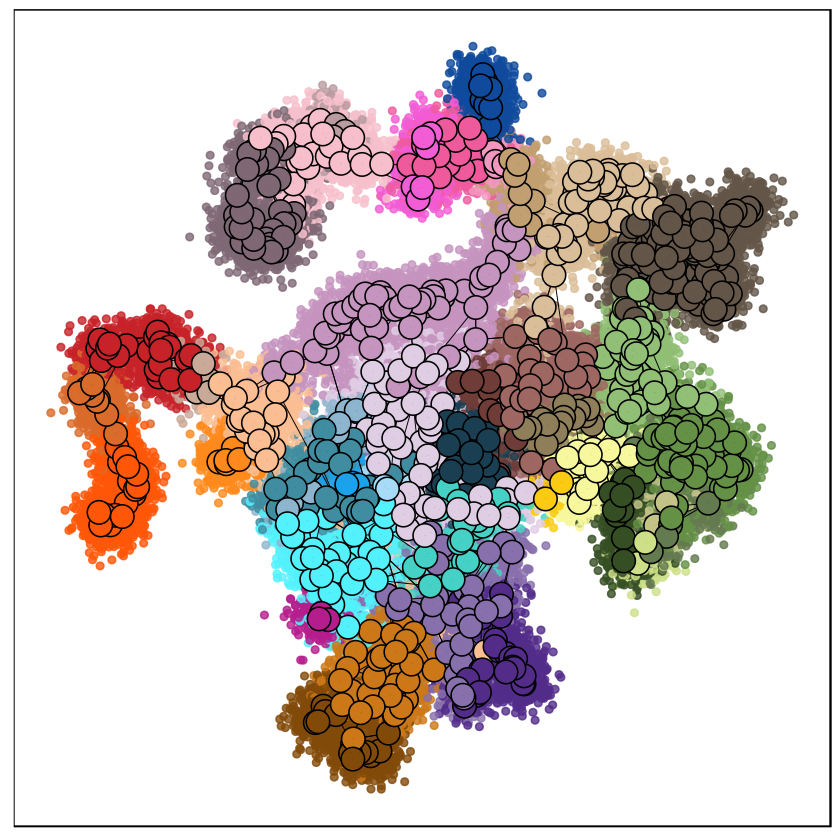

In [7]:
##### Fig1b ######
manifold2dproj_hr(mc2d_id = "emb_umap",
                  mc_id = "emb",
                  plot_mc = T,
                  sc_point_size = 1.5,
                  sc_transparency = 0.8,
                  mc_name_txt_size = 0,
                  mc_point_size = 6,
                  studio_plot = T)

   age_group_emb mean
1              1  5.6
2              2  6.0
3              3  6.4
4              4  6.5
5              5  6.6
6              6  6.8
7              7  7.0
8              8  7.3
9              9  7.5
10            10  7.6
11            11  7.7
12            12  7.8
13            13  7.9
14            14  8.0
15            15  8.2
16            16  8.3


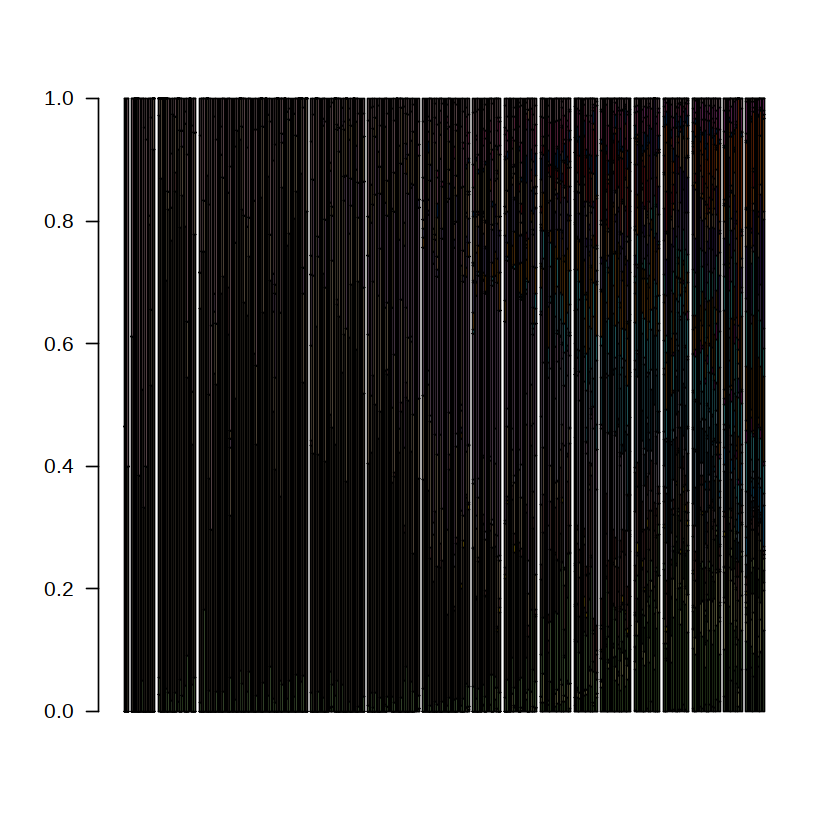

In [8]:
##### Fig1c ######
mat_wt <- scdb_mat("emb")
mc_wt <- scdb_mc("emb")

embryo_age_df = unique(mat_wt@cell_metadata[,c("embryo","transcriptional_rank",
                                                    "age_group_emb","developmental_time")])
embryo_age_df = embryo_age_df[order(embryo_age_df$transcriptional_rank),]

sum_age_embryo <- embryo_age_df %>% 
  group_by(age_group_emb) %>% 
  summarise(mean=round(mean(developmental_time),1))
sum_age_embryo <- as.data.frame(sum_age_embryo)

# mean developmental time per embryonic age group
print(sum_age_embryo[-17,])

all_cells = names(mc_wt@mc)[mc_wt@colors[mc_wt@mc] %in% mc_wt@color_key$color[1:40] & !is.na(mat_wt@cell_metadata[names(mc_wt@mc),"transcriptional_rank"])]
ct_ag = table(mc_wt@colors[mc_wt@mc[all_cells]],mat_wt@cell_metadata[all_cells,"transcriptional_rank"])
ct_ag_n = t(t(ct_ag)/colSums(ct_ag))
ct_ag_n = ct_ag_n[mc_wt@color_key$color[1:40],]

# bar plot of embryonic proper
space_between = rep(0.3,ncol(ct_ag_n))
border_age_group = c(2.5,12.5,28.5,74.5,97.5,119.5,139.5,151.5,165.5,178.5,188.5,201.5,212.5,223.5,235.5,243.5)
space_between[as.integer(border_age_group + 0.5)] = 2
barplot(ct_ag_n,col = rownames(ct_ag_n),las = 2,space = space_between,names.arg = rep("",ncol(ct_ag_n)))

Studio plot completed



ERROR: Error in stop_quietly(): 


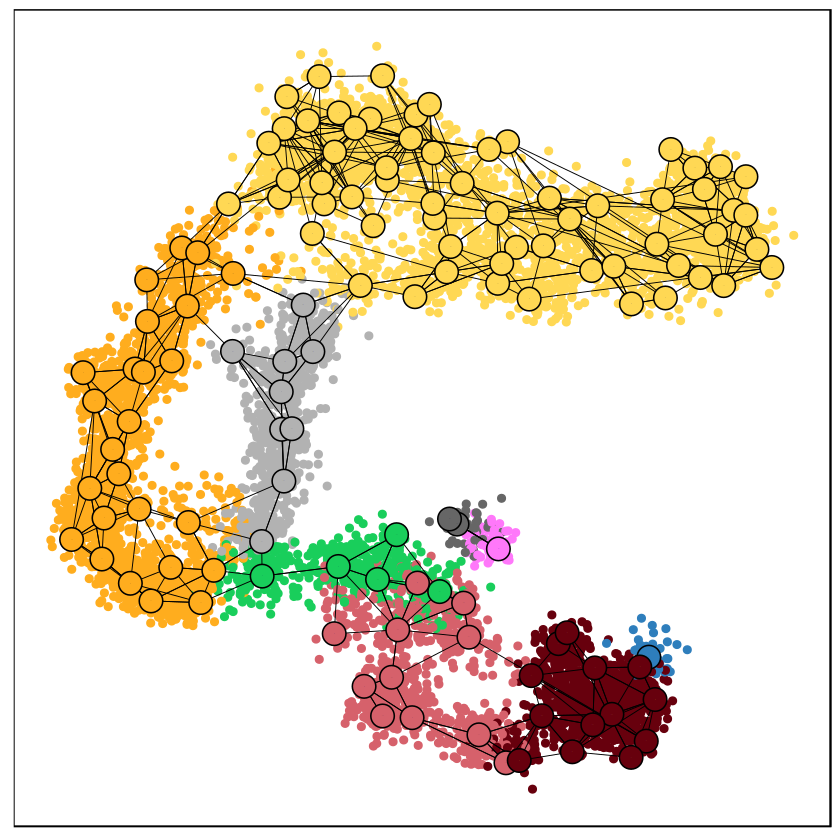

In [9]:
##### Fig1d ######
manifold2dproj_hr(mc2d_id = "exe_umap",
                  mc_id = "exe",
                  plot_mc = T,
                  sc_point_size = 1.5,
                  sc_transparency = 1,
                  mc_name_txt_size = 0,
                  mc_point_size = 6,
                  studio_plot = T)

png 
  2

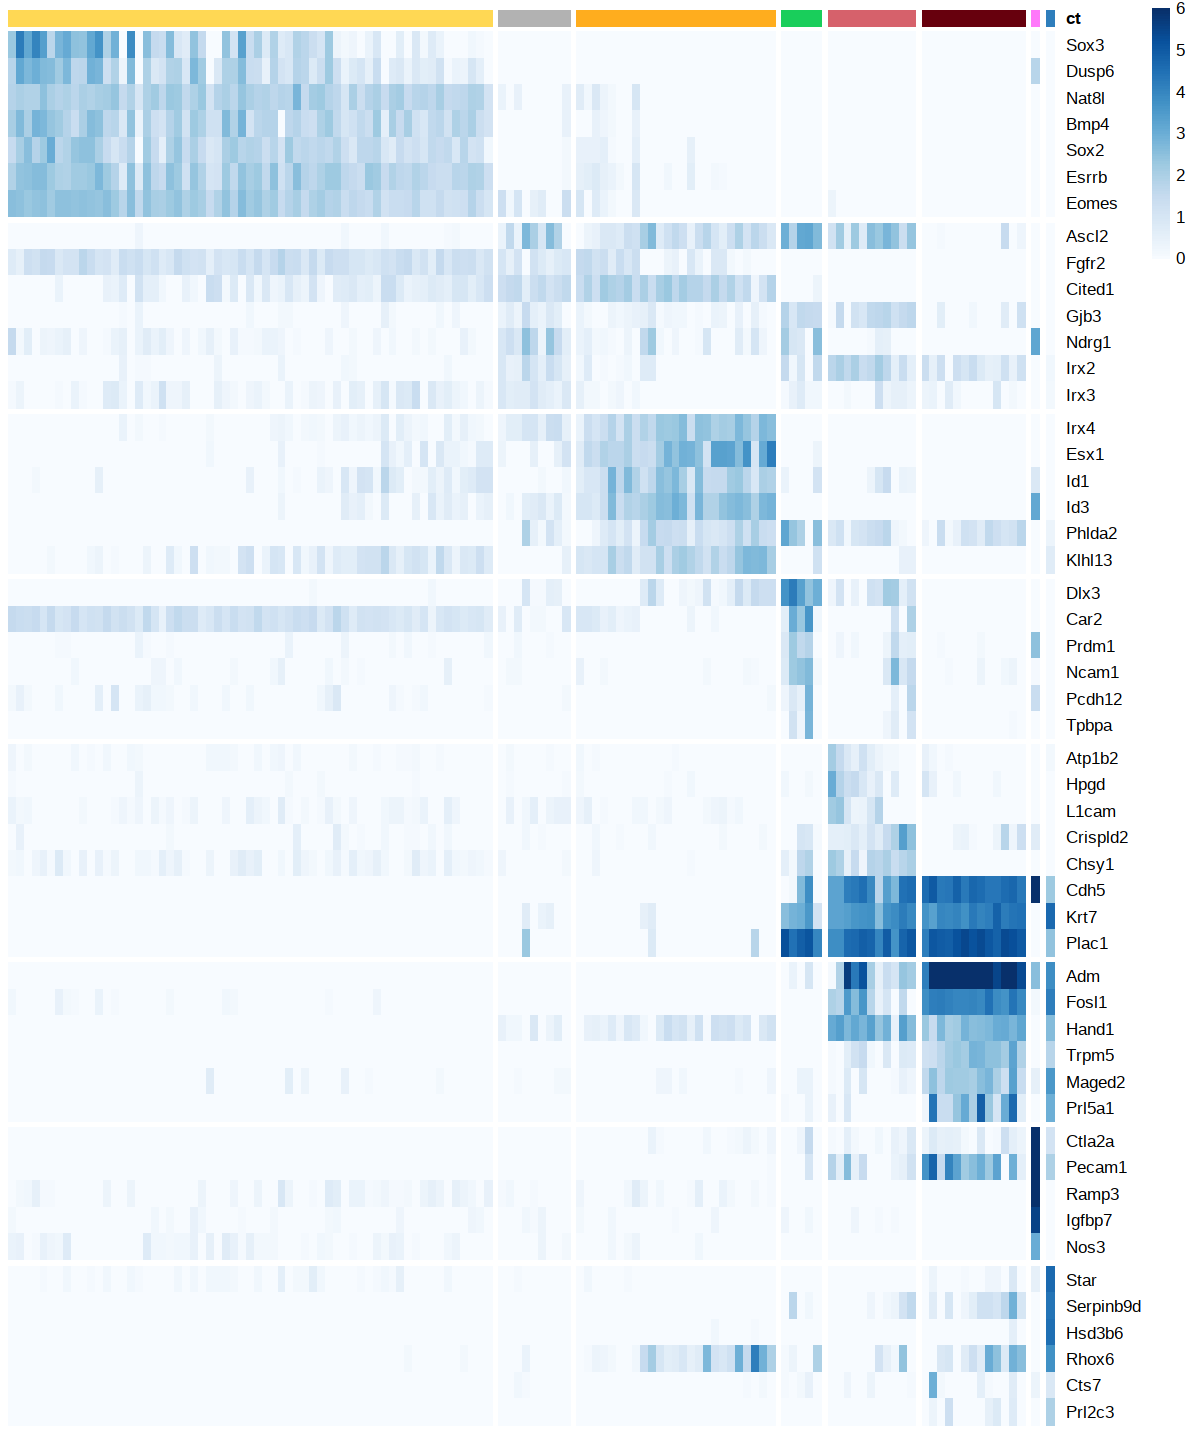

In [10]:
##### Fig 1e #####
# Genes to mark
gns.Chorion_progenitors <- c("Sox3","Dusp6","Nat8l","Bmp4","Sox2","Esrrb","Eomes")
gns.TSC2 <- c("Ascl2","Fgfr2","Cited1","Gjb3","Ndrg1","Irx2","Irx3")
gns.Chorion <- c("Irx4","Esx1","Id1","Id3","Phlda2","Klhl13")
gns.SpT <- c("Dlx3","Car2","Prdm1","Ncam1","Pcdh12","Tpbpa")
# gns.EPC_progenitors <- c("Atp1b2","Hpgd","L1cam","Chsy1","Chst2","Crim1","Irx1","Crispld2")
gns.EPC_progenitors <- c("Atp1b2","Hpgd","L1cam","Crispld2","Chsy1","Cdh5","Krt7","Plac1")
gns.TGC_progenitors <- c("Adm","Fosl1","Hand1","Trpm5","Maged2","Prl5a1")
gns.SpA <- c("Ctla2a","Pecam1","Ramp3","Igfbp7","Nos3")
gns.pTGC <- c("Star","Serpinb9d","Hsd3b6","Rhox6","Cts7","Prl2c3")

gns_heat <- c(gns.Chorion_progenitors,gns.TSC2,gns.Chorion,gns.SpT,gns.EPC_progenitors,gns.TGC_progenitors,gns.SpA,gns.pTGC)
mcs_heat <- c(tsc_mcs_ord,tsc2_mcs_ord,chorion_mcs_ord,spt_mcs_ord,epc_mcs_ord,tgc_mcs_ord,spa_mcs_ord,ptgc_mcs_ord)

gap_row <- c(length(gns.Chorion_progenitors),
             length(gns.Chorion_progenitors) + length(gns.TSC2),
             length(gns.Chorion_progenitors) + length(gns.TSC2) + length(gns.Chorion),
             length(gns.Chorion_progenitors) + length(gns.TSC2) + length(gns.Chorion) + length(gns.SpT),
             length(gns.Chorion_progenitors) + length(gns.TSC2) + length(gns.Chorion) + length(gns.SpT) + length(gns.EPC_progenitors),
             length(gns.Chorion_progenitors) + length(gns.TSC2) + length(gns.Chorion) + length(gns.SpT) + length(gns.EPC_progenitors) + length(gns.TGC_progenitors),
             length(gns.Chorion_progenitors) + length(gns.TSC2) + length(gns.Chorion) + length(gns.SpT) + length(gns.EPC_progenitors) + length(gns.TGC_progenitors) + length(gns.SpA),
             length(gns.Chorion_progenitors) + length(gns.TSC2) + length(gns.Chorion) + length(gns.SpT) + length(gns.EPC_progenitors) + length(gns.TGC_progenitors) + length(gns.SpA) + length(gns.pTGC))

gap_col <- c(length(tsc_mcs_ord),
             length(tsc_mcs_ord) + length(tsc2_mcs_ord),
             length(tsc_mcs_ord) + length(tsc2_mcs_ord) + length(chorion_mcs_ord),
             length(tsc_mcs_ord) + length(tsc2_mcs_ord) + length(chorion_mcs_ord) + length(spt_mcs_ord),
             length(tsc_mcs_ord) + length(tsc2_mcs_ord) + length(chorion_mcs_ord) + length(spt_mcs_ord) + length(epc_mcs_ord),
             length(tsc_mcs_ord) + length(tsc2_mcs_ord) + length(chorion_mcs_ord) + length(spt_mcs_ord) + length(epc_mcs_ord) + length(tgc_mcs_ord),
             length(tsc_mcs_ord) + length(tsc2_mcs_ord) + length(chorion_mcs_ord) + length(spt_mcs_ord) + length(epc_mcs_ord) + length(tgc_mcs_ord) + length(spa_mcs_ord),
             length(tsc_mcs_ord) + length(tsc2_mcs_ord) + length(chorion_mcs_ord) + length(spt_mcs_ord) + length(epc_mcs_ord) + length(tgc_mcs_ord) + length(spa_mcs_ord) + length(ptgc_mcs_ord))

lfp = log2(mc@e_gc + 1e-5)
lfp = lfp - rowMeans(lfp)
lfp = lfp[gns_heat,]
lfp = lfp[,mcs_heat]
lfp = pmax(lfp,0)
lfp = pmin(lfp,6)

options(repr.plot.width=10, repr.plot.height=12)

heatmark <- pheatmap::pheatmap(mat = lfp,
                               annotation_legend = F,
                            cluster_cols = F,
                            cluster_rows = F,
                            show_colnames = F,
                            show_rownames = T,
                            color = shades_blues,
                            annotation_col = annotation_col,
                            annotation_colors = annotation_colors,
                            border_color = "black",
                            gaps_row = gap_row,
                            gaps_col = gap_col)

pdf("../figs/fig1e.pdf", width = 10, height = 12, useDingbats = F)
print(heatmark)
dev.off()

In [16]:
##### Fig1f ######
manifold2dproj_hr(mc2d_id = "exe_umap",plot_dir = "../figs/",plot_nm = "tb",
                  mc_id = "exe",
                  mat_id = "exe",
                  plot_par = "time_bin",
                  plot_title = "Age:",
                  sc_point_size = 5,
                  studio_plot = F)

Completed



ERROR: Error in stop_quietly(): 


In [17]:
##### Fig1g + h ######
mat_exe <- scdb_mat("exe_w45")
mc_exe <- scdb_mc("exe_w45")
norm.egc <- t(t(mc_exe@e_gc)/colSums(mc_exe@e_gc))

tb1_cls <- mat@cell_metadata[mat@cell_metadata$dev_time_exe_new == "5.7","cell"]
tb1_cls <- tb1_cls[!is.na(tb1_cls)]
tb1_mcs <- unique(as.numeric(mc_exe@mc[tb1_cls]))

epc_mcs <- which(mc_exe@colors == "#D6616B")
chp_mcs <- which(mc_exe@colors %in% c("#BD9E39","#8F916B"))
tsc2_mcs <- which(mc_exe@colors == "#D6616B")
te_mcs <- which.max(mc_exe@mc_fp["Calcoco2",])

tb1_epc_mcs <- epc_mcs[epc_mcs %in% tb1_mcs]
tb1_chp_mcs <- chp_mcs[chp_mcs %in% tb1_mcs]

xlims <- c(-17,-5)
ylims <- c(-17,-5)


In [18]:
md_exe <- mat_exe@cell_metadata[names(mc_exe@mc),]
cls_e45  <- rownames(md_exe)[ md_exe$Experiment %in% c("EXE26","EXE27")]
length(cls_e45)

[1] 12

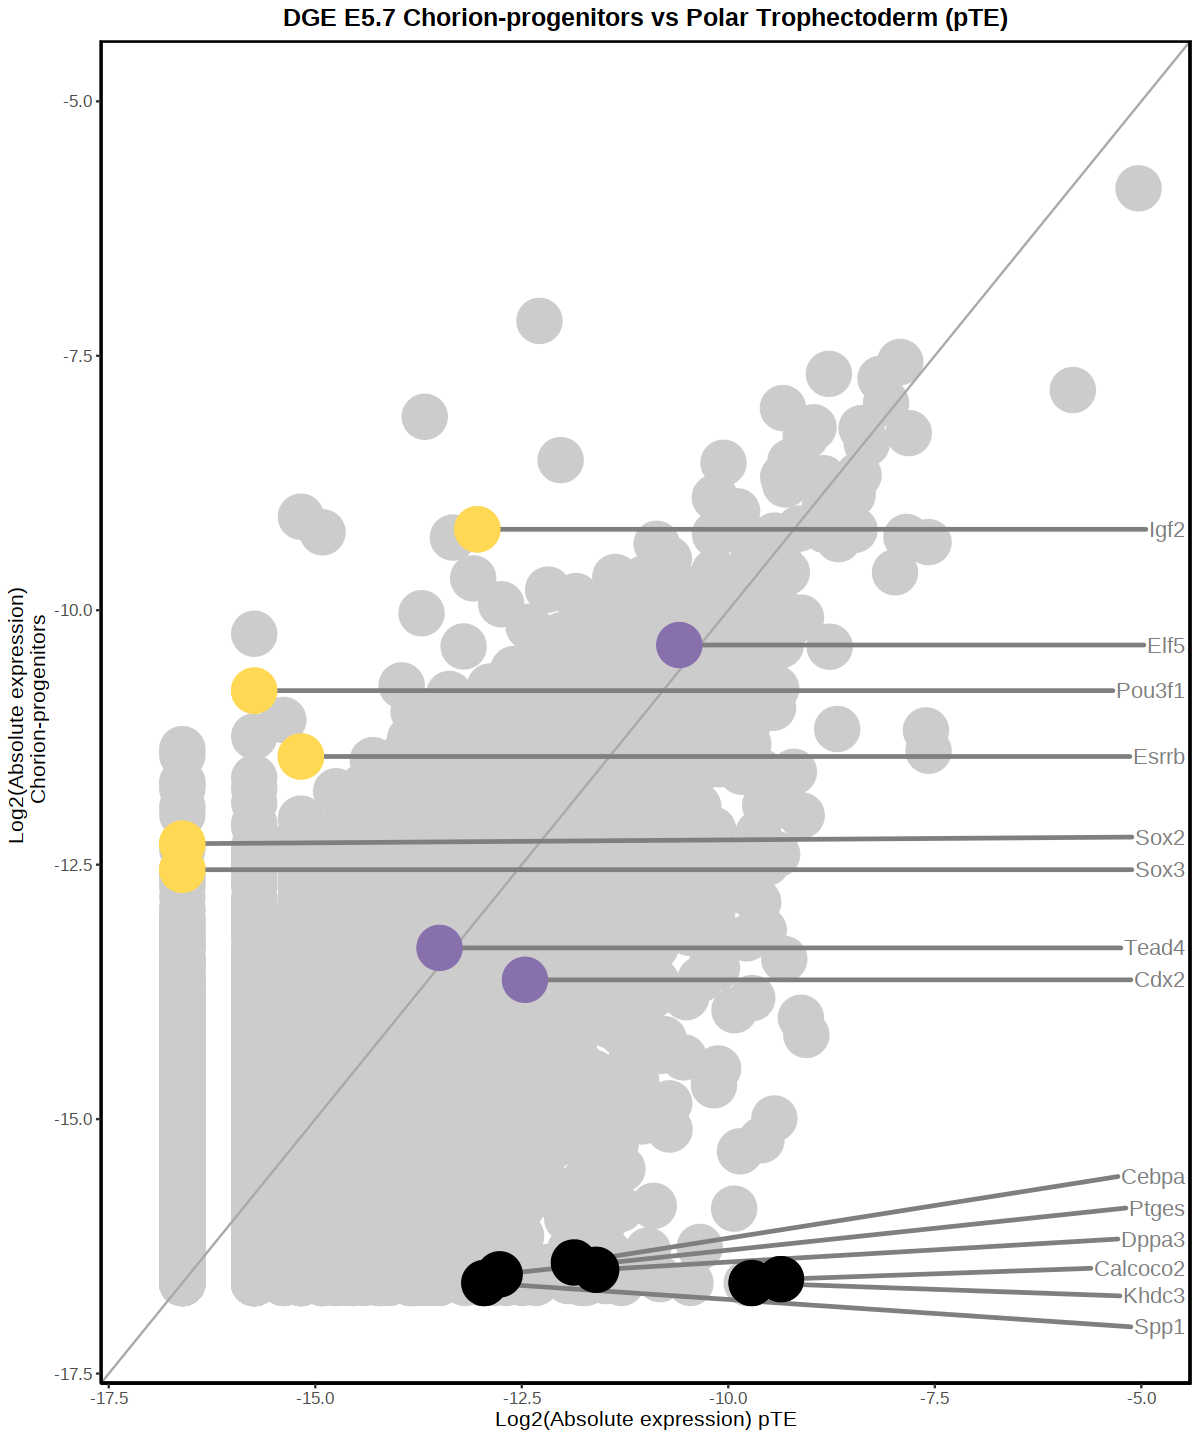

In [19]:
dge1 <- matrix(norm.egc[,te_mcs],dimnames = list(c(row.names(norm.egc))))
dge2 <- matrix(rowMeans(norm.egc[,tb1_chp_mcs]),dimnames = list(c(row.names(norm.egc))))

title.nm <- "DGE E5.7 Chorion-progenitors vs Polar Trophectoderm (pTE)"

temp <- cbind(dge2[,1],dge1[,1])
colnames(temp) <- c("gexp.2", "gexp.1")
temp <- as.data.frame(temp)
temp$log.2 <- log2(temp$gexp.2 + 1e-05)
temp$log.1 <- log2(temp$gexp.1 + 1e-05)
temp$diff.2 <- log2(temp$gexp.2 + 1e-05) - log2(temp$gexp.1 + 1e-05)
temp$diff.1 <- log2(temp$gexp.1 + 1e-05) - log2(temp$gexp.2 + 1e-05)

up <- c("Spp1", "Ptges", "Khdc3", "Cebpa", "Dppa3","Calcoco2") #pTE
dn <- c("Sox2", "Sox3", "Esrrb", "Pou3f1", "Igf2") # ChP
mark <- c("Tead4", "Cdx2", "Elf5")

rnms <- rownames(temp)
rnms <- subset(rnms , rnms %in% c(up,dn,mark))

temp$log <- NA
temp$log[rownames(temp) %in% dn] <- "dn"
temp$log[rownames(temp) %in% up] <- "up"
temp$log[rownames(temp) %in% mark] <- "mark"
temp$log[which(is.na(temp$log))] <- "n"

pa <- ggplot(data = temp,aes(log.1,log.2,col=log)) +
  geom_point(size = 12) +
  geom_abline(slope = 1,col="darkgrey") +
  ggtitle(title.nm) +
    xlim(xlims) + 
    ylim(ylims) + 
  xlab("Log2(Absolute expression) pTE") +
  ylab("Log2(Absolute expression) \n Chorion-progenitors") +
    theme(plot.title = element_text(face = "bold",hjust = 0.5)) +

  scale_color_manual(values = c("up"="#000000",
                                "dn"="#FFD854",
                                "mark"="#8870AD",
                                "n"="#CCCCCC"))

p1 <- pa  + geom_text_repel(data=subset(temp, rownames(temp) %in% rnms),
                            aes(log.1,
                                log.2,
                                label=rnms, 
                                col  = "#000000",
                                size = 10), 
                            nudge_x      = 25,
                            direction    = "y",
                            segment.size = 1) +

            geom_point(data=subset(temp, rownames(temp) %in% rnms),
                     aes(log.1,log.2), size = 12) +

            theme(legend.position = "none", text = element_text(size = 12),
                panel.border = element_rect(fill=NA, size = 1))

print(p1)

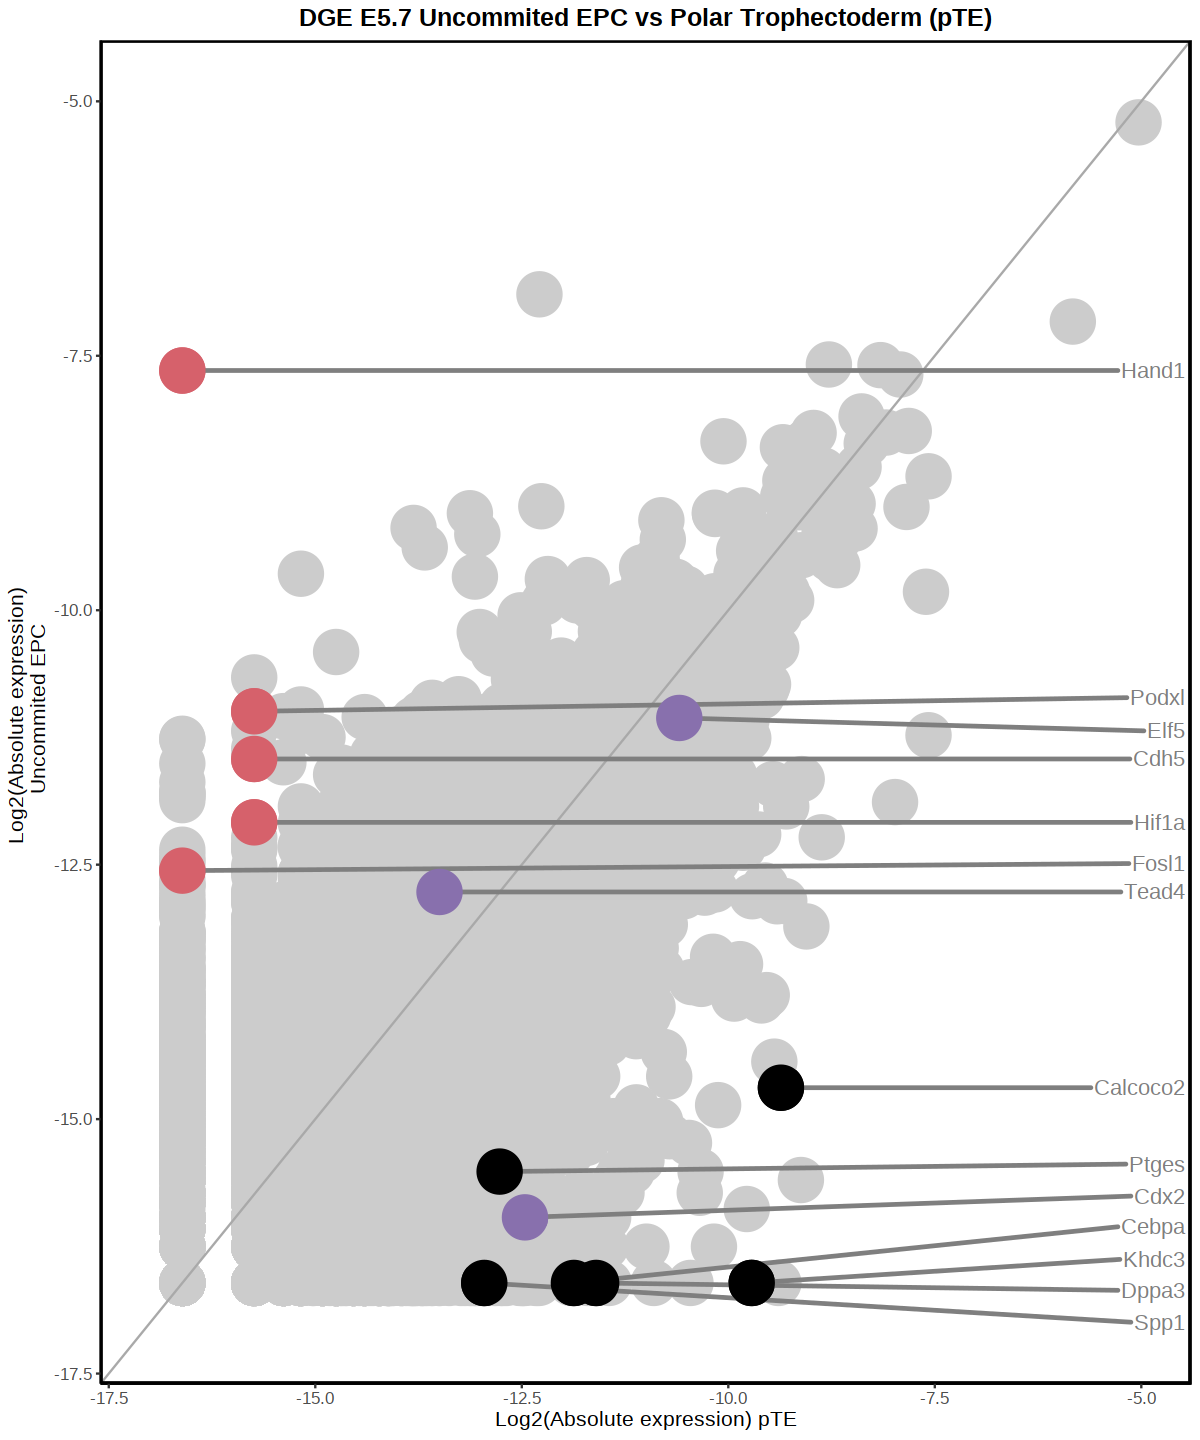

In [20]:
dge1 <- matrix(norm.egc[,te_mcs],dimnames = list(c(row.names(norm.egc))))
dge2 <- matrix(norm.egc[,tb1_epc_mcs],dimnames = list(c(row.names(norm.egc))))

title.nm <- "DGE E5.7 Uncommited EPC vs Polar Trophectoderm (pTE)"

temp <- cbind(dge2[,1],dge1[,1])
colnames(temp) <- c("gexp.2", "gexp.1")
temp <- as.data.frame(temp)
temp$log.2 <- log2(temp$gexp.2 + 1e-05)
temp$log.1 <- log2(temp$gexp.1 + 1e-05)
temp$diff.2 <- log2(temp$gexp.2 + 1e-05) - log2(temp$gexp.1 + 1e-05)
temp$diff.1 <- log2(temp$gexp.1 + 1e-05) - log2(temp$gexp.2 + 1e-05)

up <- c("Spp1", "Ptges", "slc1a1", "Cebpa", "Khdc3","Dppa3", "Calcoco2") # pTE
dn <- c("Hand1", "Cdh5", "Hif1a", "Podxl", "Fosl1", "Prl7") # EPC
mark <- c("Tead4", "Cdx2", "Elf5")

rnms <- rownames(temp)
rnms <- subset(rnms , rnms %in% c(up,dn, mark))

temp$log <- NA
temp$log[rownames(temp) %in% dn] <- "dn"
temp$log[rownames(temp) %in% up] <- "up"
temp$log[rownames(temp) %in% mark] <- "mark"
temp$log[which(is.na(temp$log))] <- "n"

pb <- ggplot(data = temp,aes(log.1,log.2,col=log)) +
  geom_point(size = 12) +
  geom_abline(slope = 1,col="darkgrey") +
  ggtitle(title.nm) +
    xlim(xlims) + 
    ylim(ylims) + 
  xlab("Log2(Absolute expression) pTE") +
  ylab("Log2(Absolute expression) \n Uncommited EPC") +
    theme(plot.title = element_text(face = "bold",hjust = 0.5),
        panel.border = element_rect(fill=NA, size = 1)) +

  scale_color_manual(values = c("up"="#000000",
                                "dn"="#D6616B",
                                "mark"="#8870AD",
                                "n"="#CCCCCC"))

p2 <- pb  + geom_text_repel(data=subset(temp, rownames(temp) %in% rnms),
                            aes(log.1,
                                log.2,
                                label=rnms, 
                                col  = "#000000",
                                size = 10), 
                            nudge_x      = 25,
                            direction    = "y",
                            segment.size = 1) +

            geom_point(data=subset(temp, rownames(temp) %in% rnms),
                     aes(log.1,log.2), size = 12) +

            theme(legend.position = "none", text = element_text(size = 12),
                panel.border = element_rect(fill=NA, size = 1))

print(p2)

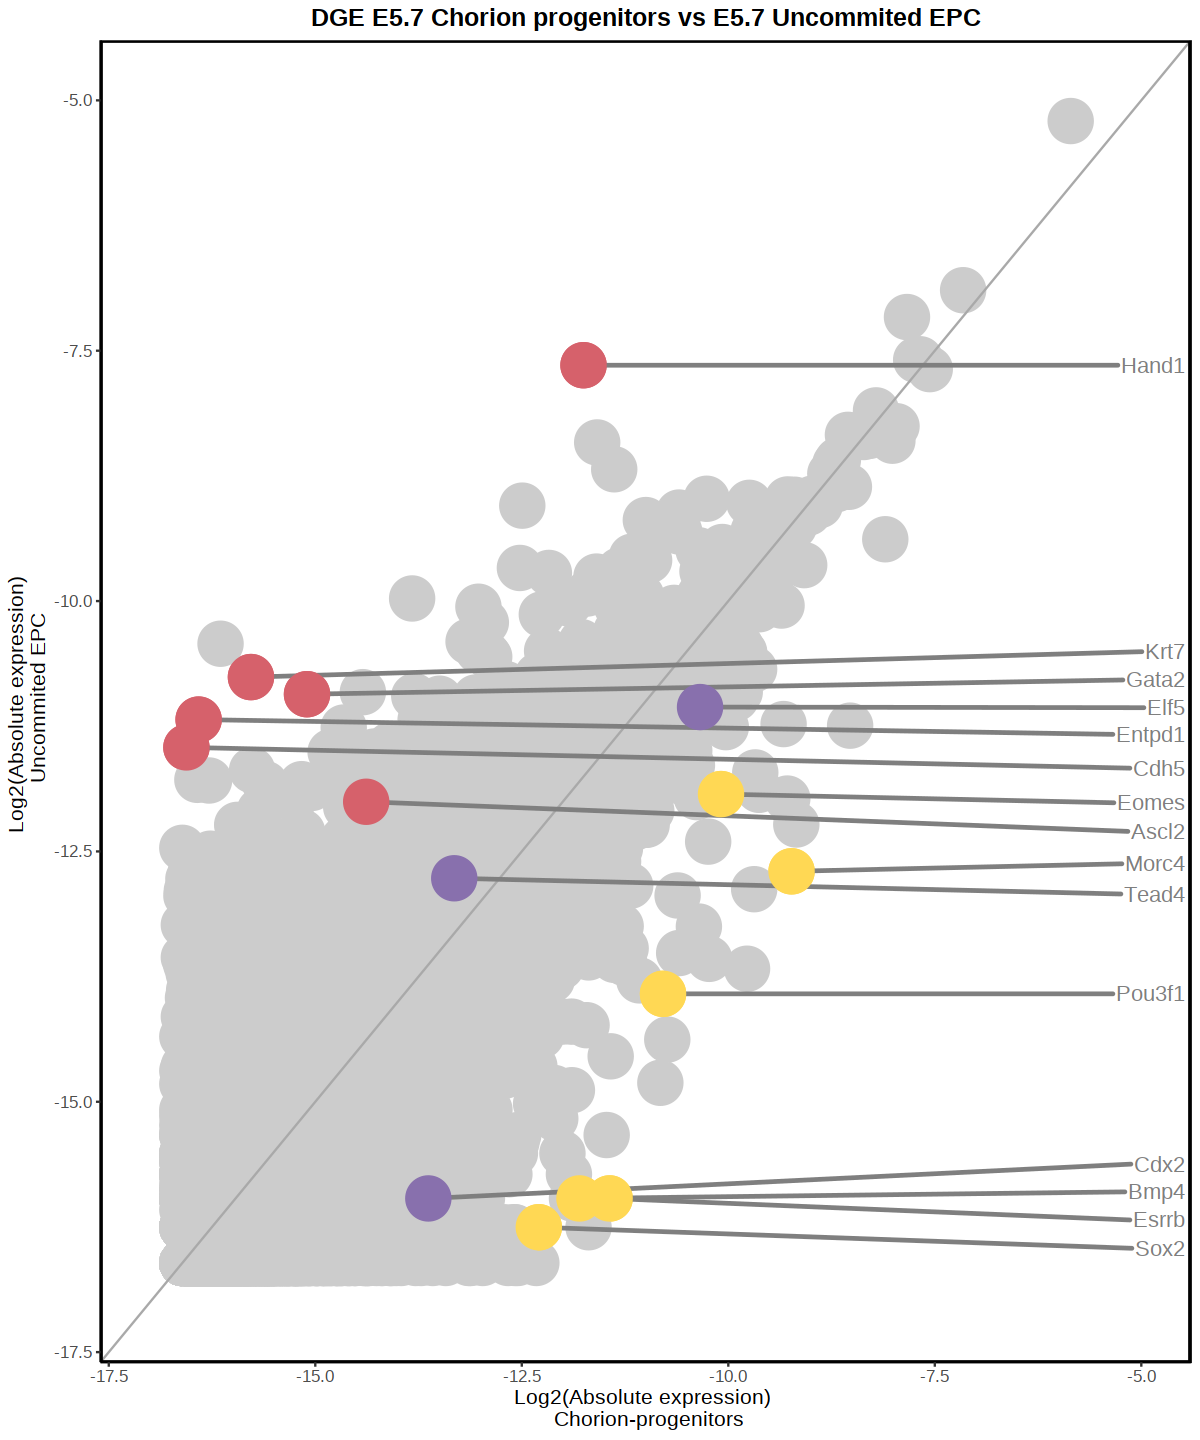

In [21]:
dge1 <- matrix(rowMeans(norm.egc[,tb1_chp_mcs]),dimnames = list(c(row.names(norm.egc))))
dge2 <- matrix(norm.egc[,tb1_epc_mcs],dimnames = list(c(row.names(norm.egc))))

title.nm <- "DGE E5.7 Chorion progenitors vs E5.7 Uncommited EPC"

temp <- cbind(dge2[,1],dge1[,1])
rownames(temp)[rownames(temp) == "AK053895;Morc4"] <- "Morc4"
colnames(temp) <- c("gexp.2", "gexp.1")
temp <- as.data.frame(temp)
temp$log.2 <- log2(temp$gexp.2 + 1e-05)
temp$log.1 <- log2(temp$gexp.1 + 1e-05)
temp$diff.2 <- log2(temp$gexp.2 + 1e-05) - log2(temp$gexp.1 + 1e-05)
temp$diff.1 <- log2(temp$gexp.1 + 1e-05) - log2(temp$gexp.2 + 1e-05)

up <- c("Eomes", "Pou3f1", "Morc4", "Esrrb", "Bmp4", "Sox2")
dn <- c("Hand1", "Krt7", "Gata2", "Ascl2", "Entpd1", "Cdh5")
mark <- c("Tead4", "Cdx2", "Elf5")

rnms <- rownames(temp)
rnms <- subset(rnms , rnms %in% c(up,dn,mark))

temp$log <- NA
temp$log[rownames(temp) %in% dn] <- "dn"
temp$log[rownames(temp) %in% up] <- "up"
temp$log[rownames(temp) %in% mark] <- "mark"
temp$log[which(is.na(temp$log))] <- "n"


pc <- ggplot(data = temp,aes(log.1,log.2,col=log)) +
  geom_point(size = 12) +
  geom_abline(slope = 1,col="darkgrey") +
  ggtitle(title.nm) +
    xlim(xlims) + 
    ylim(ylims) + 
  xlab("Log2(Absolute expression) \n Chorion-progenitors") +
  ylab("Log2(Absolute expression) \n Uncommited EPC") +
    theme(plot.title = element_text(face = "bold",hjust = 0.5),
        panel.border = element_rect(fill=NA, size = 1)) +

  scale_color_manual(values = c("up"="#FFD854",
                                "dn"="#D6616B",
                                "mark"="#8870AD",
                                "n"="#CCCCCC"))

p3 <- pc  + geom_text_repel(data=subset(temp, rownames(temp) %in% rnms),
                            aes(log.1,
                                log.2,
                                label=rnms, 
                                col  = "#000000",
                                size = 10), 
                            nudge_x      = 25,
                            direction    = "y",
                            segment.size = 1) +

            geom_point(data=subset(temp, rownames(temp) %in% rnms),
                     aes(log.1,log.2), size = 12) +

            theme(legend.position = "none", text = element_text(size = 12),
                panel.border = element_rect(fill=NA, size = 1))
print(p3)

### Fig 1i

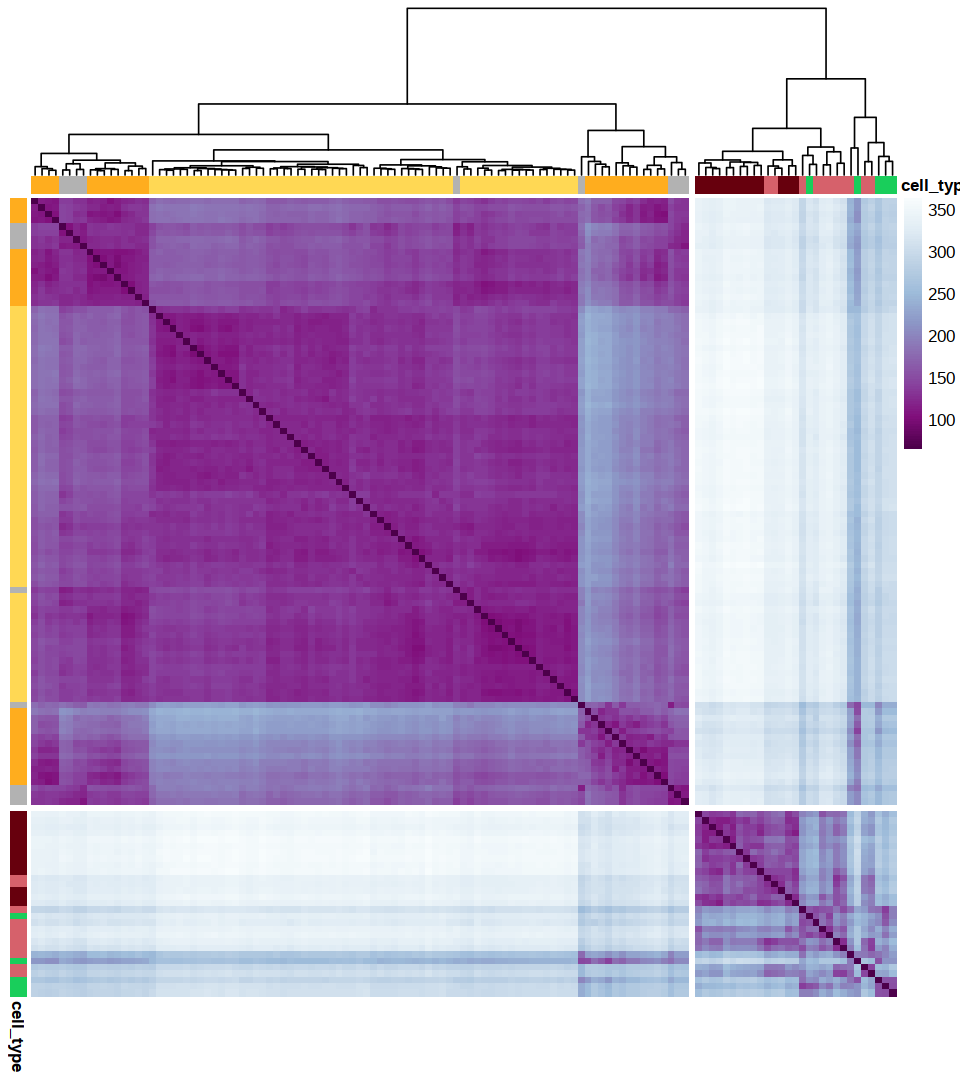

In [40]:
feat_genes = intersect(names(gset@gene_set),rownames(mc@e_gc))
legc = log2(mc@e_gc + 1e-5)

filtered_mcs = which(mc@colors %in% mc@color_key$color[1:6])

# logistic distance
loc = 1
scale = 0.5
logist_d = function(x) {
    d = abs(legc[feat_genes,] - x)
    d = plogis(d, loc, scale)
    return(colSums(d))
}

mc_mc_logist_dist = apply(legc[feat_genes,], 2, logist_d)

options(repr.plot.width=8, repr.plot.height=9)

annotation_mcs = data.frame(cell_type = col_to_ct[mc@colors])
rownames(annotation_mcs) = c(1:ncol(mc@e_gc))
annotation_colors = list(cell_type = ct_to_col)

pheatmap::pheatmap(mc_mc_logist_dist[filtered_mcs,filtered_mcs],cutree_cols = 2,cutree_rows = 2,
                   color = rev(shades_purples),
                   annotation_col = annotation_mcs,
                   annotation_row = annotation_mcs,
                   annotation_colors = annotation_colors,
                   annotation_legend = F,
                   treeheight_row = 0, 
                   treeheight_col = 100,
                   border_color = NA, 
                   show_rownames = F, 
                   show_colnames = F)